In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from misc_scripts.fun_factor_update import *
from pycmqlib3.strategy.signal_repo import signal_store, custom_funda_signal

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [5]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


In [6]:
from bktest.backtest_grid_search import *

tday = datetime.date.today()
roll_name = 'hot'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=tday,
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d',
    shift_mode=2
)

if len(error_list) > 0:
    print(error_list)

spot_df = get_fun_data(datetime.date(2008,1,1), tday)    
#print(spot_df)

In [11]:
scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.155, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0945, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0758, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0595, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0484, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.151, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.0844, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.22, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.502, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.420, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.527, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.163, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.147, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.143, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0406, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0381, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.0369, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.119, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.117, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.122, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.120, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.125, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.137, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.456, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),    
]

scenarios_prod = [
    ('tscarry', 'ryieldnmb', 0.1213, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.2727, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.184, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0103, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0532, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.1204, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.4054, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.3380, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.102, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.5282, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.1997, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.4554, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5546, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.0, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.4524, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.04414, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.1458, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.2731, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.1708, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.3562, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.6, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),    
    ('funda', 'io_removal_lvl', 0.8, 1, 1, 1, ['i',], None),
    ('funda', 'io_removal_lyoy', 0.8, 1, 1, 1, ['i', 'rb', 'hc',], None),    
    ('funda', 'io_millinv_lyoy', 0.8, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc',], None),
    ('funda', 'io_invdays_lyoy', 0.8, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'SM', 'SF', 'v', 'FG', 'al'], None),
    ('funda', 'io_invdays_lvl', 0.8, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'SM', 'SF', 'v', 'FG', 'al'], None),
    ('funda', 'strip_hsec_lvl_mid', 0.8, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'v', 'FG', 'SF', 'al'], None),
    ('funda', 'steel_margin_lvl_fast', 0.8, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'FG', 'SF'], None),  
    
    ('funda', 'steel_sinv_lyoy_zs', 0.4, 1, 1, 1, ['i', 'rb', 'hc', 'v', 'FG'], None),
    ('funda', 'steel_sinv_lyoy_mds', 0.4, 1, 1, 1, ['i', 'rb', 'hc', 'v', 'FG'], None),    
    ('funda', 'rbhc_dmd_mds', 2.4, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'rbhc_dmd_lyoy_mds', 2.4, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'rbhc_sinv_mds', 2.4, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'rbhc_sinv_lyoy_mds', 2.4, 1, 1, 3, ['rb', 'hc'], None),
    
    ('funda', 'lme_base_ts_mds', 0.8, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn', 'pb'], None),
    ('funda', 'lme_base_ts_hlr', 0.8, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn', 'pb'], None),
    ('funda', 'cu_prem_usd_zsa', 0.8, 1, 1, 1, ['cu'], None),
    ('funda', 'cu_prem_usd_md', 0.8, 1, 1, 1, ['cu'], None),
    ('funda', 'cu_phybasis_zsa', 0.8, 1, 1, 1, ['cu'], None),
    ('funda', 'cu_phybasis_hlr', 0.8, 1, 1, 1, ['cu'], None),     
]


In [8]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

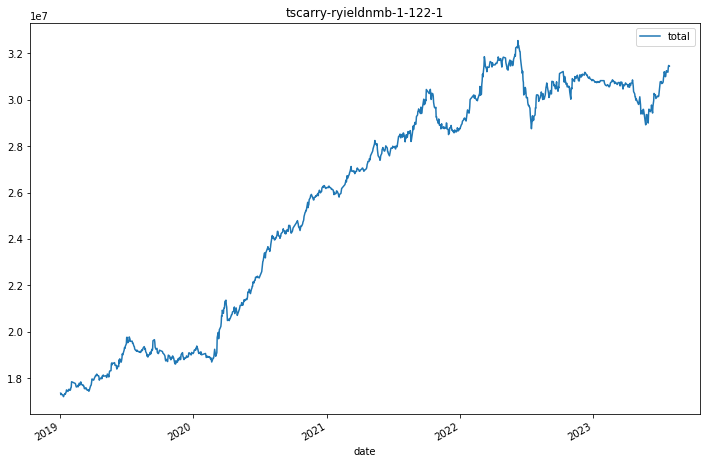

       sharpe        std  sortino
tenor                            
all      1.74   92739.49     2.54
6m       0.57  137542.13     0.90
1y       0.82  141038.91     1.38
2y       0.64  153697.04     1.04
3y       1.25  135620.94     1.95
4y       1.51  130347.07     2.37
5y       1.58  124691.12     2.49
6y       1.65  116935.18     2.58
7y       1.81  112366.11     2.82
8y       1.71  109378.77     2.65
9y       1.70  105617.09     2.61
10y      1.74  101613.91     2.65
11y      1.79   98355.44     2.71


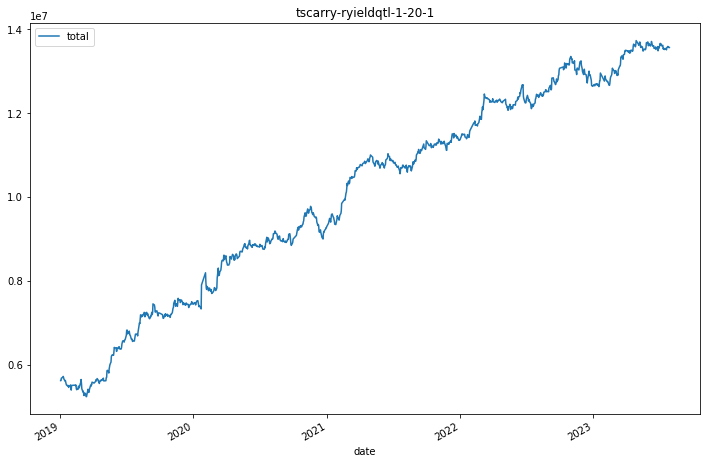

       sharpe       std  sortino
tenor                           
all      1.40  49680.08     2.21
6m       1.45  52830.92     2.43
1y       1.32  59063.98     2.18
2y       1.56  57959.23     2.47
3y       1.75  56358.02     2.88
4y       1.82  60467.51     3.17
5y       1.87  58750.24     3.27
6y       1.61  57631.15     2.78
7y       1.58  56286.09     2.72
8y       1.54  56218.29     2.57
9y       1.40  55270.67     2.34
10y      1.50  53691.88     2.47
11y      1.49  52025.11     2.42


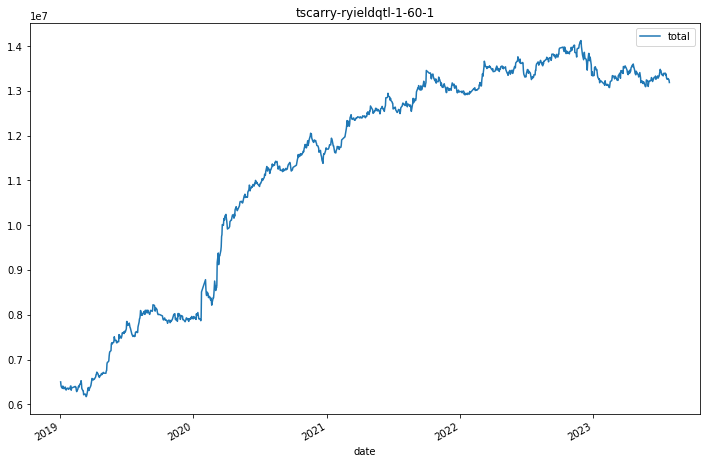

       sharpe       std  sortino
tenor                           
all      1.34  50333.71     2.12
6m      -0.11  54224.22    -0.21
1y      -0.28  61636.58    -0.44
2y       0.26  58919.93     0.44
3y       0.74  56337.92     1.25
4y       1.40  63883.19     2.53
5y       1.59  61756.95     2.83
6y       1.42  59640.51     2.46
7y       1.49  58452.03     2.58
8y       1.38  57275.76     2.31
9y       1.26  56133.51     2.10
10y      1.38  54481.11     2.28
11y      1.41  52673.67     2.31


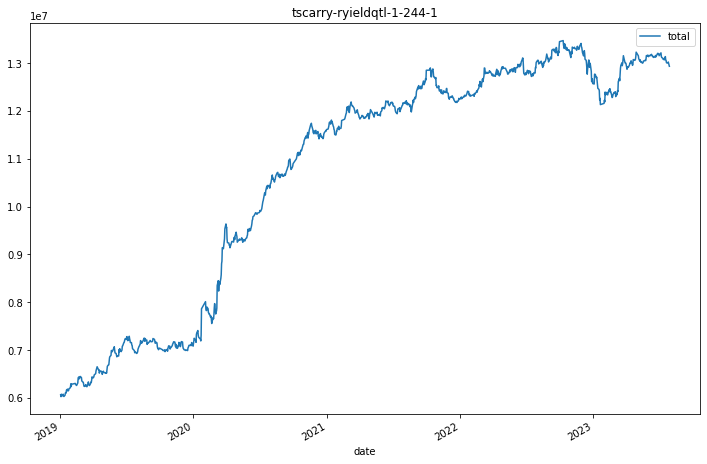

       sharpe       std  sortino
tenor                           
all      1.46  45376.54     2.14
6m       1.93  52315.53     3.58
1y       0.04  62939.13     0.06
2y       0.45  57638.44     0.70
3y       0.98  54145.37     1.51
4y       1.58  60694.79     2.57
5y       1.52  58658.68     2.44
6y       1.53  55787.13     2.44
7y       1.60  54190.43     2.57
8y       1.49  53474.61     2.33
9y       1.43  51873.95     2.24
10y      1.45  49881.69     2.26
11y      1.50  48089.17     2.32


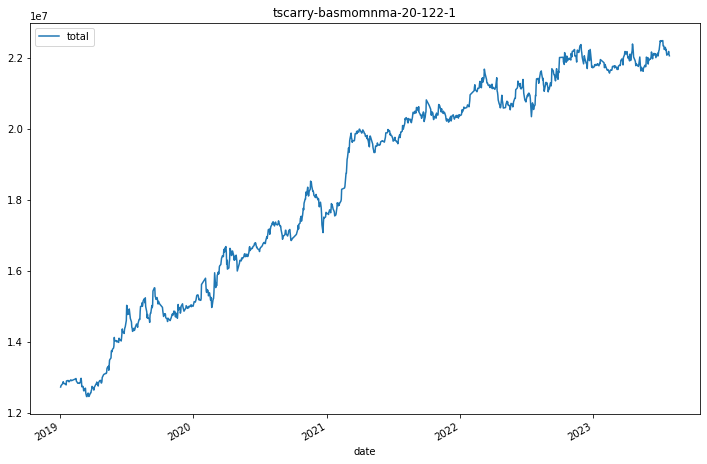

       sharpe        std  sortino
tenor                            
all      1.29   87197.59     1.89
6m       0.16   86380.74     0.27
1y       0.68  105903.23     1.20
2y       0.62  101602.16     1.07
3y       1.06   98649.39     1.79
4y       1.22  100879.81     1.96
5y       1.39  100627.91     2.26
6y       1.21   99307.39     1.90
7y       1.27   97167.68     2.00
8y       1.27   99895.38     1.97
9y       1.10   98203.54     1.69
10y      1.29   94593.26     1.95
11y      1.35   91244.39     2.02


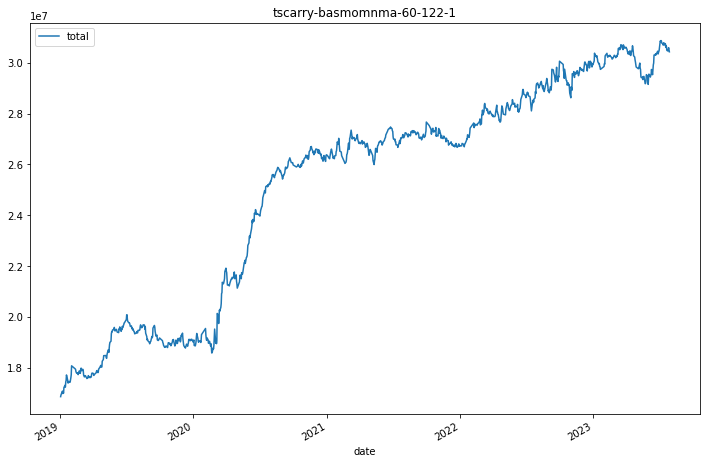

       sharpe        std  sortino
tenor                            
all      1.40  111428.65     2.12
6m       0.76  113984.65     1.43
1y       0.73  144371.92     1.37
2y       0.82  129230.57     1.48
3y       0.91  121479.28     1.60
4y       1.38  128751.94     2.42
5y       1.47  127919.55     2.46
6y       1.40  124389.47     2.29
7y       1.57  122522.49     2.59
8y       1.47  128509.21     2.35
9y       1.39  125138.41     2.21
10y      1.43  120745.01     2.27
11y      1.50  117085.95     2.35


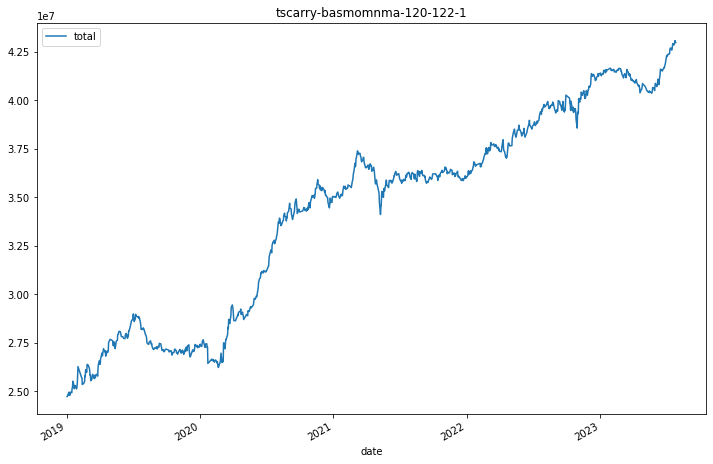

       sharpe        std  sortino
tenor                            
all      1.53  144026.34     2.25
6m       1.68  107367.36     3.11
1y       1.44  157076.51     2.40
2y       1.48  145219.80     2.48
3y       1.42  153086.27     2.22
4y       1.55  152815.99     2.34
5y       1.69  156853.15     2.59
6y       1.68  153984.67     2.57
7y       1.83  152057.11     2.87
8y       1.80  166692.96     2.80
9y       1.60  163365.21     2.51
10y      1.59  156682.62     2.47
11y      1.64  152117.97     2.54


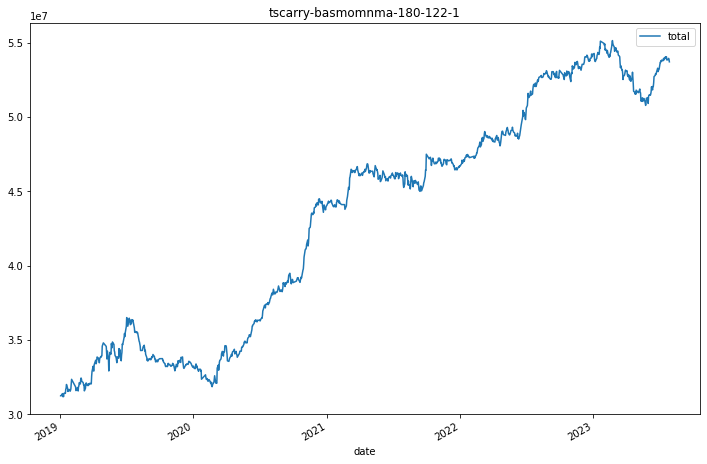

       sharpe        std  sortino
tenor                            
all      1.38  199586.34     1.98
6m      -0.85  207061.89    -1.35
1y       0.53  195309.26     0.84
2y       1.23  198357.67     2.15
3y       1.78  194717.13     3.06
4y       1.55  187740.75     2.57
5y       1.55  202161.04     2.50
6y       1.54  203009.72     2.43
7y       1.70  197975.49     2.71
8y       1.71  229433.53     2.78
9y       1.51  228934.52     2.35
10y      1.56  219646.14     2.39
11y      1.52  211585.93     2.31


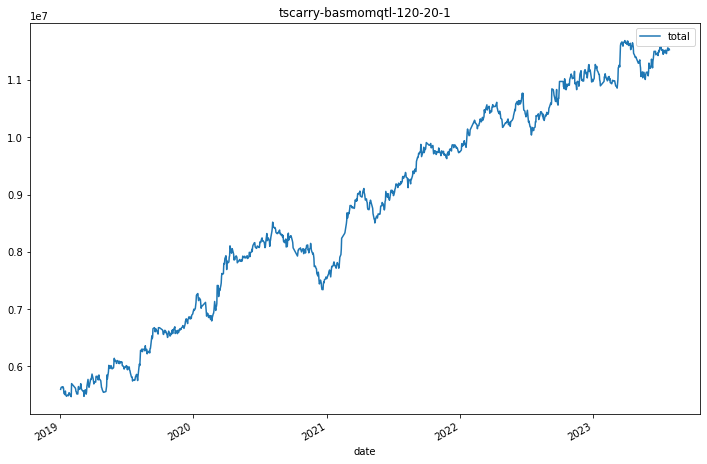

       sharpe       std  sortino
tenor                           
all      1.23  48157.45     1.88
6m       1.30  61060.76     2.22
1y       1.20  67429.25     1.91
2y       1.17  60914.66     1.88
3y       1.21  59116.84     1.94
4y       1.54  59500.39     2.50
5y       1.47  58282.24     2.44
6y       1.50  56797.55     2.49
7y       1.58  55584.05     2.61
8y       1.39  55719.31     2.29
9y       1.23  54263.76     2.02
10y      1.30  52469.36     2.10
11y      1.31  50770.19     2.10


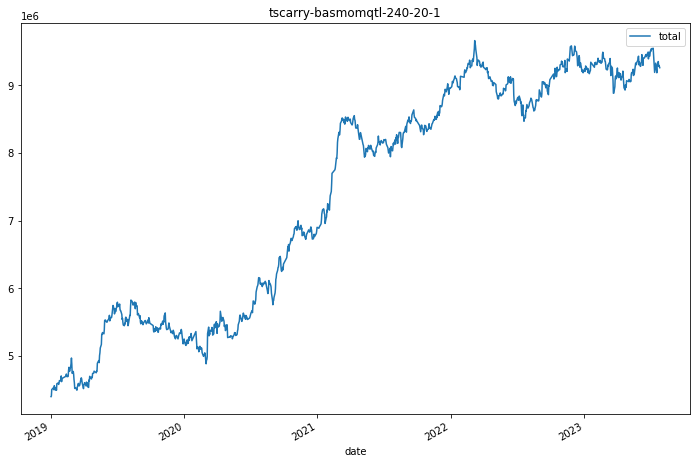

       sharpe       std  sortino
tenor                           
all      1.03  45793.92     1.48
6m      -0.16  65305.41    -0.25
1y       0.66  62493.88     1.05
2y       0.63  59080.88     0.95
3y       1.15  57942.69     1.76
4y       1.03  57514.98     1.60
5y       1.31  55765.71     2.06
6y       1.39  54406.28     2.18
7y       1.14  53133.90     1.81
8y       1.06  53175.11     1.64
9y       1.04  51998.01     1.59
10y      1.07  50288.61     1.62
11y      1.11  48549.14     1.66


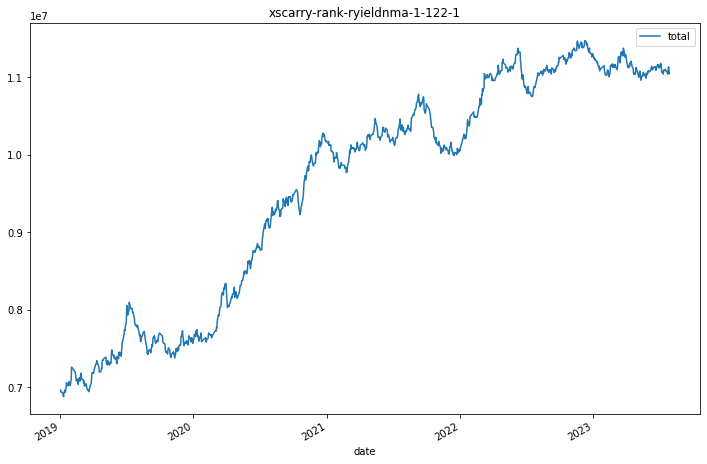

       sharpe       std  sortino
tenor                           
all      1.67  35243.09     2.66
6m      -0.19  37371.13    -0.30
1y       0.25  35147.17     0.42
2y       0.60  40083.30     0.92
3y       1.03  41522.10     1.67
4y       1.24  41952.24     2.02
5y       1.52  42133.66     2.58
6y       1.64  40950.34     2.76
7y       1.63  40401.32     2.77
8y       1.61  39959.80     2.73
9y       1.55  39043.53     2.59
10y      1.66  38001.63     2.75
11y      1.71  36693.25     2.79


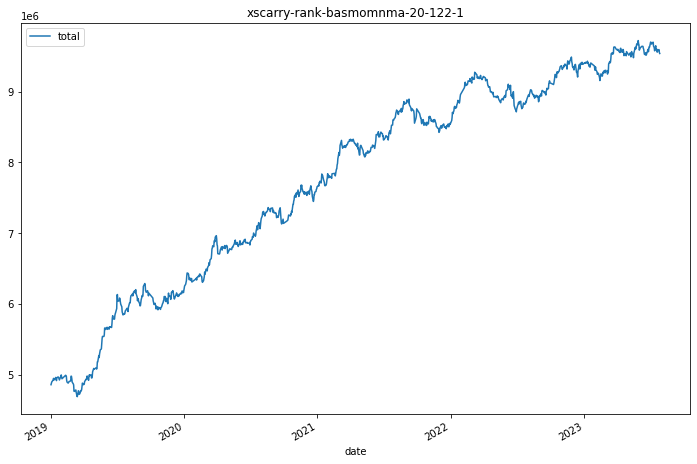

       sharpe       std  sortino
tenor                           
all      1.65  30932.66     2.60
6m       0.47  35860.05     0.97
1y       1.27  34585.68     2.30
2y       0.87  34667.35     1.44
3y       1.45  35636.65     2.39
4y       1.64  35509.69     2.69
5y       1.96  35801.26     3.27
6y       1.79  35843.40     2.91
7y       1.62  35524.31     2.66
8y       1.62  34802.62     2.65
9y       1.44  34101.86     2.35
10y      1.55  33132.63     2.52
11y      1.62  31972.15     2.59


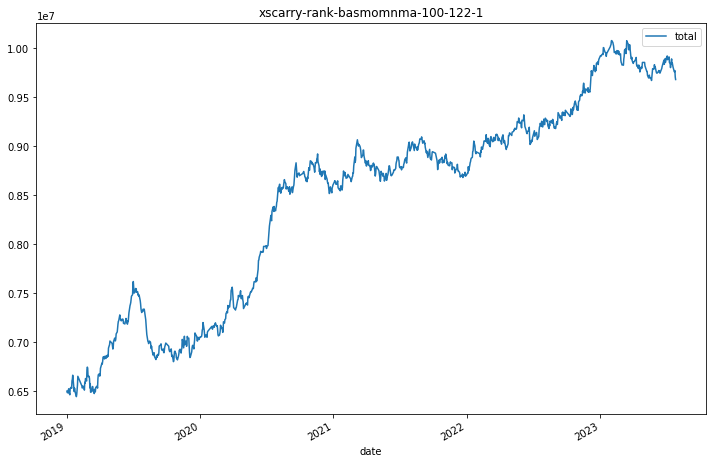

       sharpe       std  sortino
tenor                           
all      1.68  31748.71     2.71
6m      -1.01  33177.07    -1.63
1y       0.89  34376.69     1.54
2y       0.62  33708.49     1.04
3y       0.81  35479.44     1.33
4y       1.07  35742.31     1.76
5y       1.28  37073.75     2.11
6y       1.44  36603.13     2.34
7y       1.51  36293.22     2.51
8y       1.65  35814.18     2.75
9y       1.66  34756.63     2.76
10y      1.66  33646.94     2.74
11y      1.70  32509.08     2.77


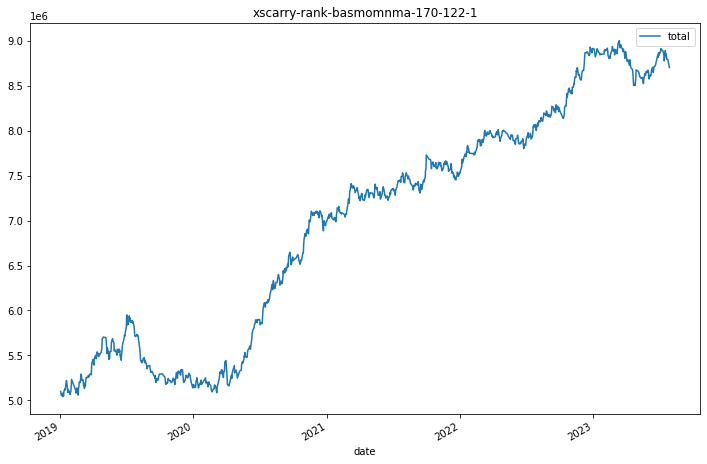

       sharpe       std  sortino
tenor                           
all      1.60  30747.96     2.58
6m      -0.52  35329.42    -0.90
1y       1.25  34768.91     2.20
2y       1.12  33540.93     2.01
3y       1.60  34447.95     2.79
4y       1.41  34192.82     2.40
5y       1.42  36140.23     2.40
6y       1.58  35092.95     2.62
7y       1.60  34593.00     2.70
8y       1.67  34185.83     2.78
9y       1.60  33218.30     2.64
10y      1.71  32281.16     2.79
11y      1.68  31149.56     2.71


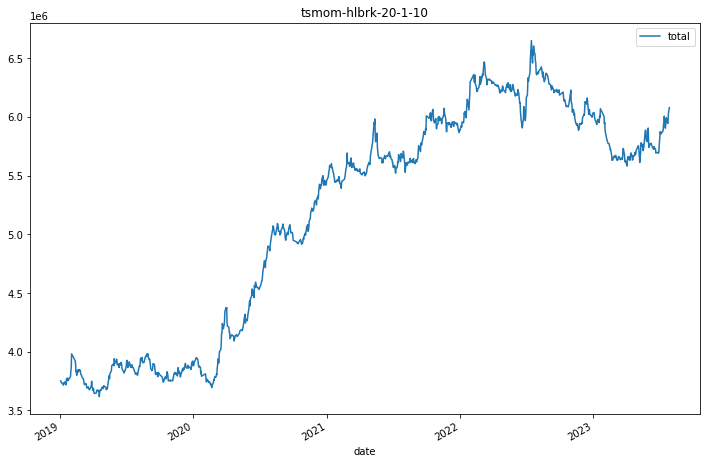

       sharpe       std  sortino
tenor                           
all      1.08  28870.17     1.56
6m       0.03  37768.26     0.04
1y      -0.72  34139.87    -0.96
2y       0.37  37593.39     0.53
3y       0.72  35635.12     1.03
4y       1.07  34124.55     1.54
5y       1.05  32504.73     1.53
6y       0.94  31359.62     1.37
7y       0.95  31342.80     1.43
8y       1.04  31504.11     1.56
9y       1.08  31729.54     1.60
10y      1.12  30726.82     1.65
11y      1.12  29851.89     1.65


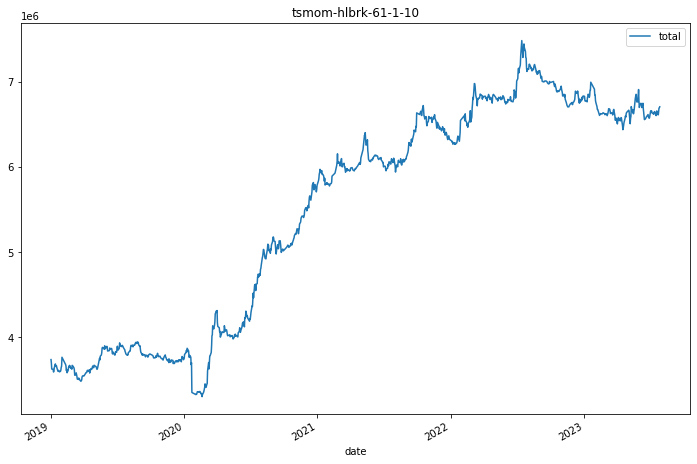

       sharpe       std  sortino
tenor                           
all      1.06  32238.72     1.49
6m      -0.89  40858.74    -1.16
1y      -1.02  35766.24    -1.33
2y       0.52  40778.34     0.77
3y       1.07  39109.16     1.58
4y       1.17  39881.66     1.57
5y       1.14  37574.78     1.55
6y       0.95  35901.05     1.32
7y       0.96  35651.61     1.36
8y       1.05  35900.13     1.52
9y       1.09  35504.49     1.56
10y      1.11  34296.34     1.58
11y      1.10  33419.34     1.55


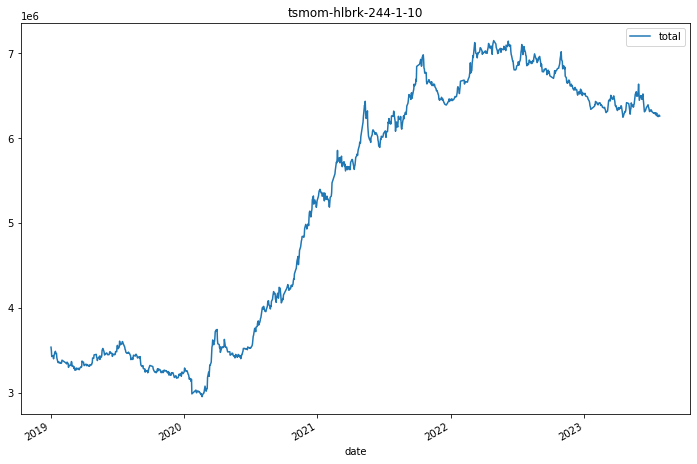

       sharpe       std  sortino
tenor                           
all      1.04  30718.49     1.44
6m      -0.30  33221.84    -0.40
1y      -1.42  32015.33    -1.95
2y       0.00  36971.36     0.01
3y       1.28  40506.40     1.92
4y       1.17  38229.63     1.70
5y       1.04  35638.00     1.52
6y       0.95  33478.20     1.36
7y       1.02  33793.60     1.50
8y       0.97  34446.86     1.43
9y       1.06  34456.79     1.54
10y      1.11  33309.18     1.62
11y      1.10  32440.06     1.58


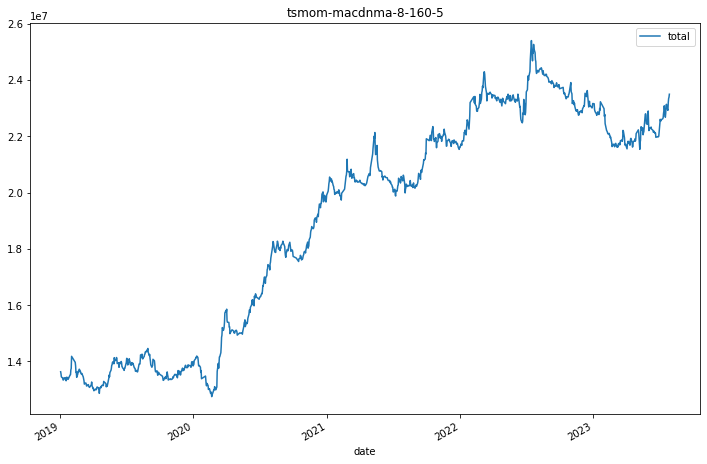

       sharpe        std  sortino
tenor                            
all      1.08  111359.75     1.53
6m       0.21  158654.62     0.27
1y      -0.55  137069.84    -0.70
2y       0.65  151928.83     0.95
3y       0.90  145046.30     1.29
4y       1.15  138074.00     1.65
5y       1.03  130269.65     1.51
6y       0.90  125387.18     1.33
7y       0.94  123976.29     1.42
8y       0.96  126078.59     1.44
9y       1.01  124105.67     1.50
10y      1.02  119435.46     1.49
11y      1.04  116133.89     1.51


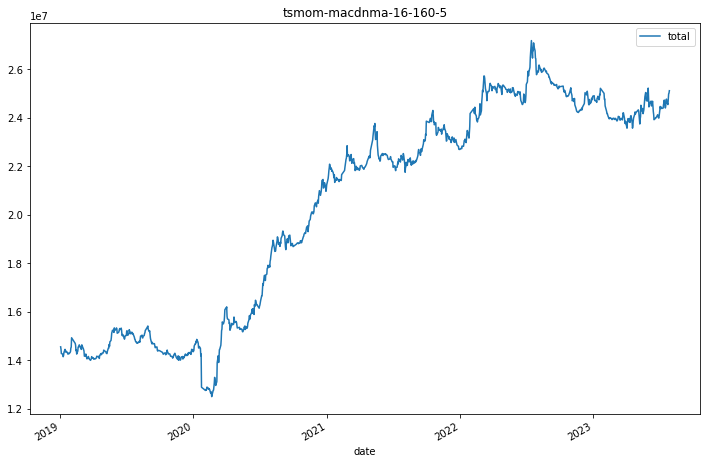

       sharpe        std  sortino
tenor                            
all      1.06  121661.50     1.44
6m      -0.08  162873.54    -0.11
1y      -0.60  140255.69    -0.80
2y       0.58  158130.36     0.86
3y       1.01  152658.39     1.47
4y       1.08  153535.46     1.43
5y       1.00  143693.19     1.34
6y       0.84  137758.83     1.15
7y       0.88  136601.00     1.23
8y       0.95  138181.74     1.35
9y       1.02  135733.47     1.44
10y      1.03  130395.51     1.44
11y      1.03  127069.52     1.43


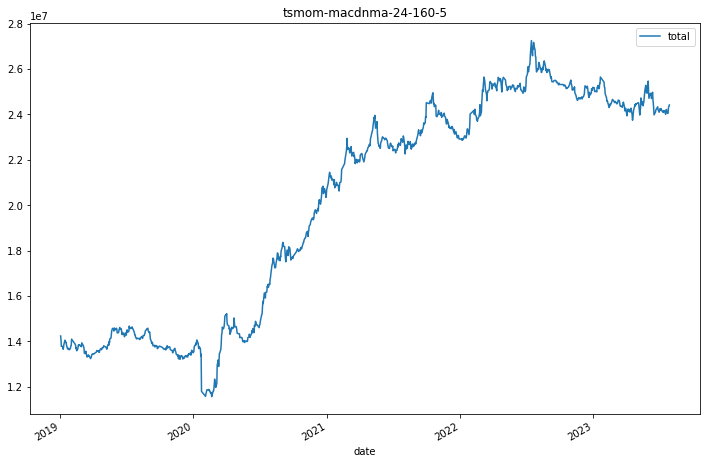

       sharpe        std  sortino
tenor                            
all      1.00  125366.08     1.33
6m      -0.99  156029.80    -1.37
1y      -0.98  138515.67    -1.31
2y       0.33  157670.62     0.49
3y       1.08  156287.86     1.59
4y       1.03  159447.48     1.33
5y       0.94  148799.49     1.23
6y       0.76  141985.44     1.01
7y       0.81  141171.99     1.10
8y       0.91  143174.20     1.26
9y       0.99  139871.90     1.36
10y      1.01  134331.20     1.38
11y      0.99  130954.90     1.35


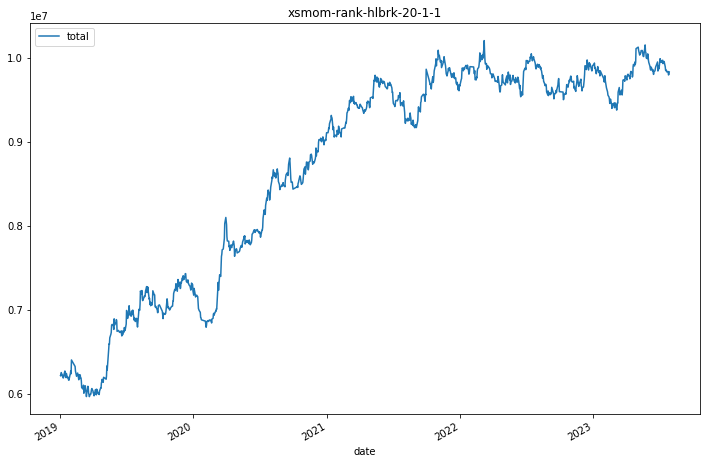

       sharpe       std  sortino
tenor                           
all      1.25  40369.95     2.02
6m      -0.04  46068.08    -0.07
1y      -0.08  44265.42    -0.13
2y       0.24  49588.51     0.40
3y       0.65  48066.48     1.07
4y       0.97  49015.07     1.63
5y       0.93  49090.65     1.58
6y       1.11  47999.10     1.88
7y       0.81  46758.51     1.36
8y       0.91  45736.82     1.52
9y       0.99  44921.36     1.66
10y      1.15  43740.08     1.92
11y      1.21  42332.38     1.99


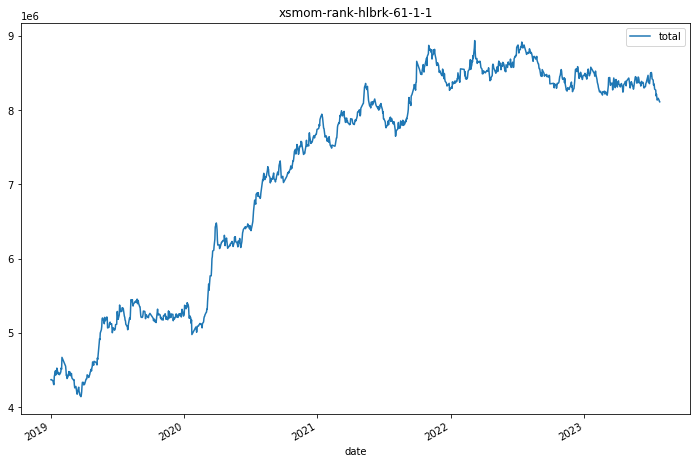

       sharpe       std  sortino
tenor                           
all      1.03  41185.12     1.63
6m      -1.31  44717.01    -2.34
1y      -0.98  43402.26    -1.54
2y       0.18  49840.53     0.30
3y       0.56  48630.03     0.94
4y       0.97  49453.44     1.65
5y       0.99  49367.63     1.68
6y       0.94  48345.98     1.58
7y       0.69  47123.27     1.14
8y       0.75  45993.73     1.23
9y       0.79  45383.97     1.30
10y      0.93  44221.57     1.52
11y      0.99  42795.93     1.59


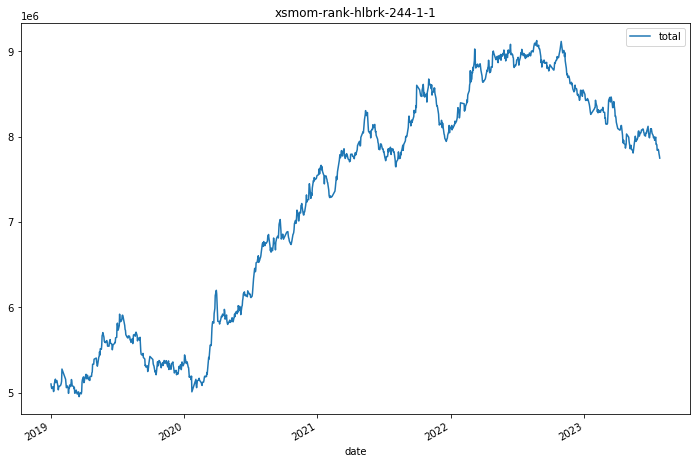

       sharpe       std  sortino
tenor                           
all      1.10  39314.64     1.69
6m      -1.50  42964.17    -2.47
1y      -1.96  39165.51    -3.11
2y      -0.07  46856.72    -0.12
3y       0.55  46714.51     0.91
4y       0.71  46616.10     1.17
5y       0.77  46076.96     1.26
6y       0.84  44474.72     1.36
7y       0.79  44132.33     1.27
8y       0.76  43355.49     1.21
9y       0.82  42560.72     1.30
10y      0.98  41217.08     1.53
11y      1.01  39917.58     1.57


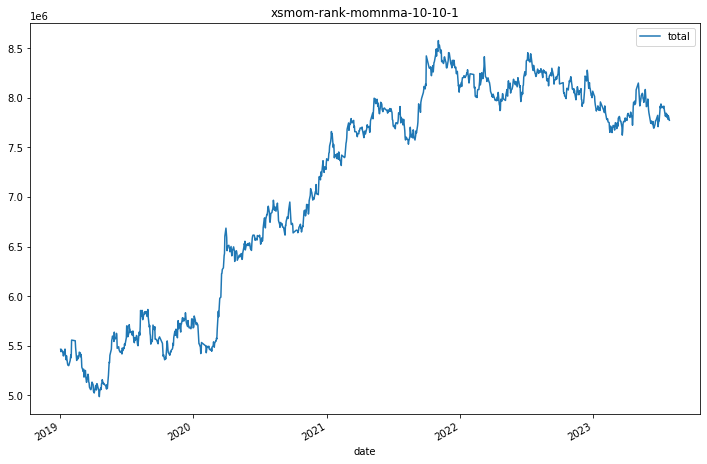

       sharpe       std  sortino
tenor                           
all      1.00  40146.27     1.60
6m      -0.50  46829.13    -0.77
1y      -0.62  45377.59    -0.92
2y      -0.01  49675.87    -0.01
3y       0.41  48509.04     0.65
4y       0.72  49181.73     1.18
5y       0.60  48668.18     1.00
6y       0.82  47363.07     1.36
7y       0.60  46230.68     1.00
8y       0.70  45329.26     1.16
9y       0.82  44637.99     1.35
10y      0.95  43340.78     1.55
11y      0.98  41950.18     1.59


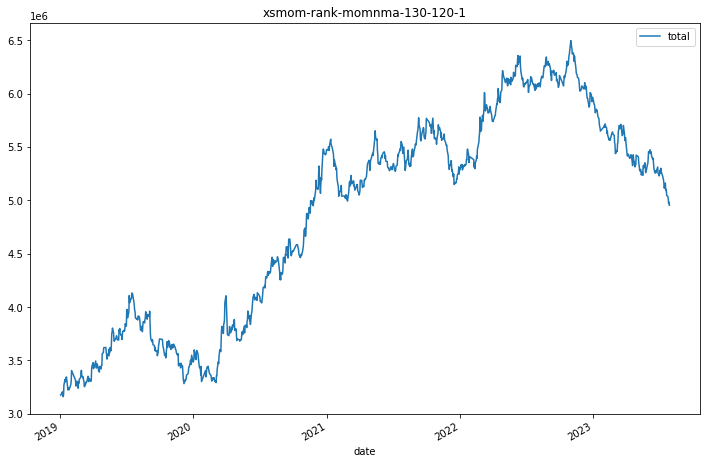

       sharpe       std  sortino
tenor                           
all      0.73  37604.12     1.14
6m      -2.24  39035.29    -3.86
1y      -1.87  38236.04    -3.25
2y      -0.37  44271.94    -0.60
3y       0.29  45234.62     0.48
4y       0.38  44851.38     0.61
5y       0.51  44238.20     0.84
6y       0.63  42845.83     1.01
7y       0.55  42569.48     0.90
8y       0.57  41742.56     0.92
9y       0.58  40624.45     0.93
10y      0.66  39343.89     1.05
11y      0.67  38127.00     1.05


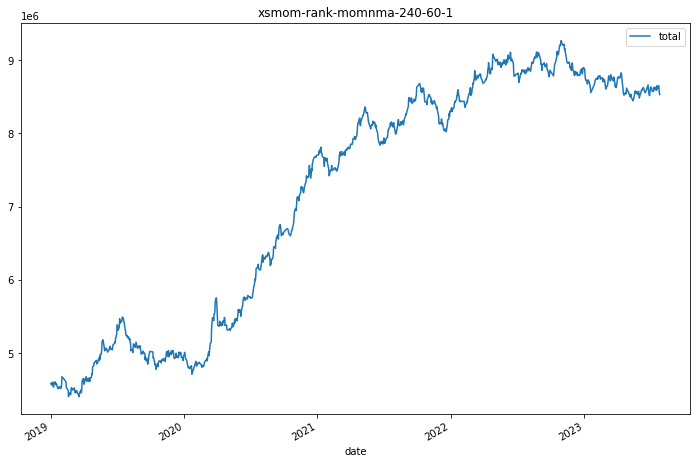

       sharpe       std  sortino
tenor                           
all      1.33  36249.44     2.12
6m      -0.08  39335.73    -0.13
1y      -0.53  38534.16    -0.86
2y       0.35  40974.56     0.55
3y       1.23  41556.83     1.98
4y       1.25  42241.51     2.00
5y       1.23  41479.43     2.00
6y       1.24  40743.67     2.03
7y       1.29  40366.05     2.12
8y       1.25  39631.40     2.05
9y       1.21  38730.06     1.97
10y      1.28  37491.96     2.06
11y      1.28  36469.73     2.02


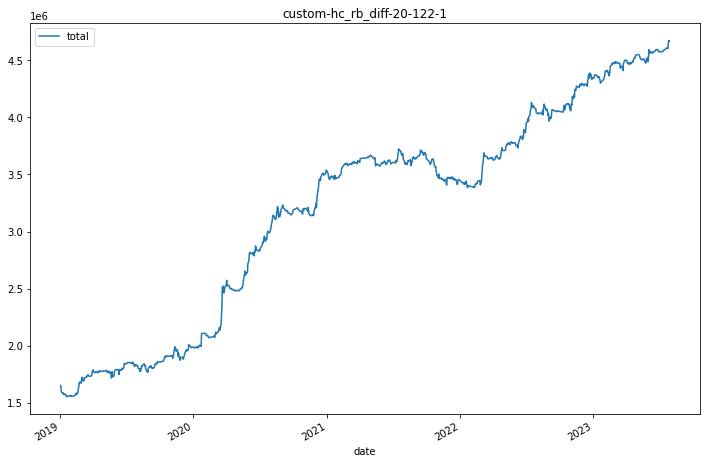

       sharpe       std  sortino
tenor                           
all      1.70  19404.99     2.72
6m       2.89  16035.19     5.40
1y       2.01  18866.02     3.39
2y       1.68  18896.03     3.03
3y       1.96  18355.55     3.40
4y       2.35  19448.90     4.23
5y       2.00  19161.64     3.28
6y       1.70  18850.09     2.79
7y       1.72  19566.73     2.74
8y       1.70  20002.43     2.77
9y       1.68  19460.50     2.70
10y      1.70  19404.99     2.72
11y      1.70  19404.99     2.72


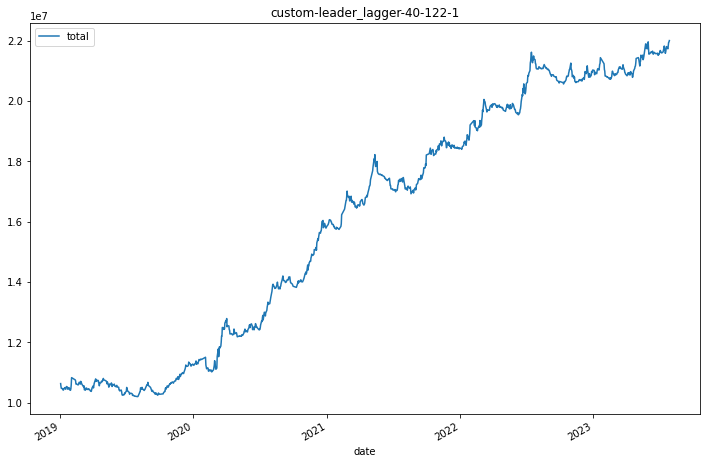

       sharpe       std  sortino
tenor                           
all      1.79  63055.71     2.54
6m       0.86  83125.57     1.10
1y       0.65  76455.35     0.84
2y       1.70  88387.78     2.58
3y       2.14  87224.25     3.25
4y       2.23  85052.12     3.31
5y       1.98  80664.86     3.01
6y       1.85  76678.65     2.81
7y       1.91  74254.71     2.91
8y       1.96  73950.43     3.00
9y       1.91  72486.75     2.85
10y      1.91  69633.74     2.81
11y      1.86  66821.35     2.69


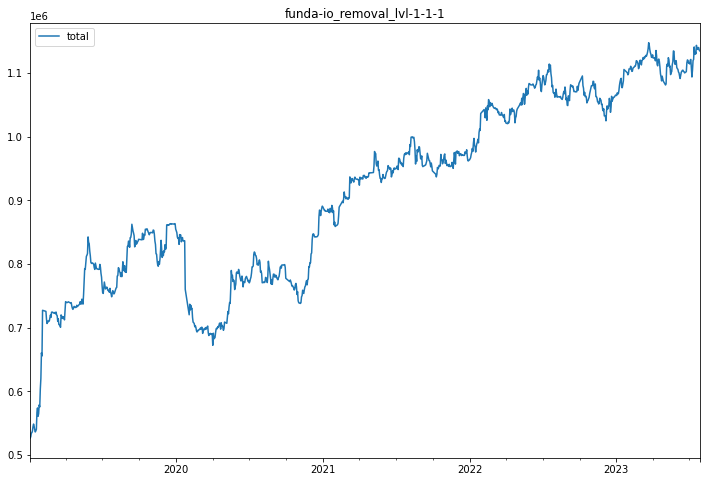

       sharpe      std  sortino
tenor                          
all      1.24  7868.21     1.84
6m       0.53  6892.88     0.94
1y       0.51  6813.24     0.80
2y       0.74  6989.22     1.17
3y       1.02  6874.38     1.62
4y       0.80  7549.56     1.07
5y       1.09  7962.23     1.62
6y       1.16  7765.21     1.72
7y       1.24  7858.15     1.85
8y       1.24  7868.21     1.84
9y       1.24  7868.21     1.84
10y      1.24  7868.21     1.84
11y      1.24  7868.21     1.84


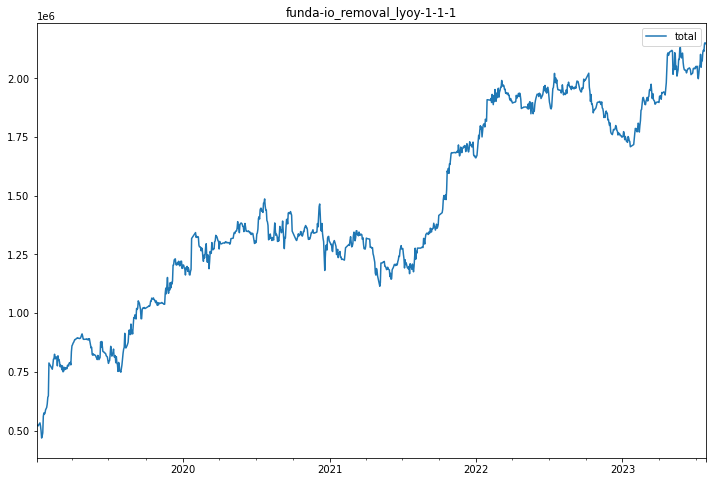

       sharpe       std  sortino
tenor                           
all      1.02  20816.87     1.48
6m       2.40  23028.35     2.95
1y       0.64  19601.70     0.84
2y       1.52  19876.30     2.20
3y       0.74  20568.91     1.05
4y       1.06  20646.71     1.55
5y       0.95  20819.05     1.41
6y       0.99  21021.11     1.47
7y       1.02  20816.87     1.48
8y       1.02  20816.87     1.48
9y       1.02  20816.87     1.48
10y      1.02  20816.87     1.48
11y      1.02  20816.87     1.48


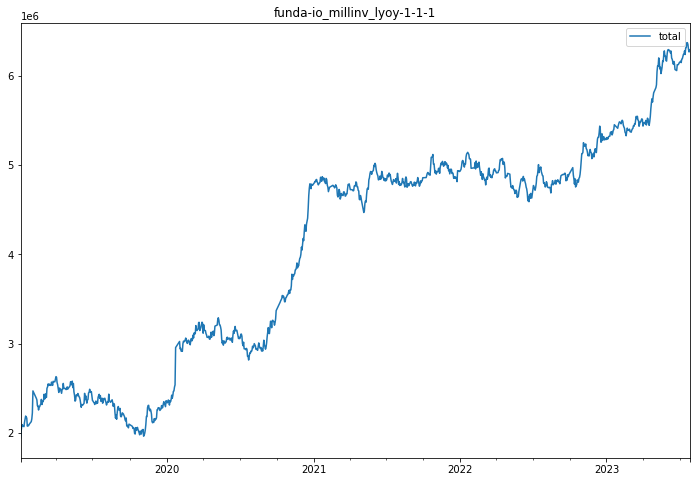

       sharpe       std  sortino
tenor                           
all      1.58  41730.01     2.68
6m       2.70  39268.39     4.79
1y       2.25  40271.49     3.61
2y       1.19  40439.41     1.88
3y       1.81  40296.74     2.98
4y       1.51  42152.58     2.57
5y       1.56  42032.76     2.66
6y       1.63  41729.32     2.76
7y       1.58  41730.01     2.68
8y       1.58  41730.01     2.68
9y       1.58  41730.01     2.68
10y      1.58  41730.01     2.68
11y      1.58  41730.01     2.68


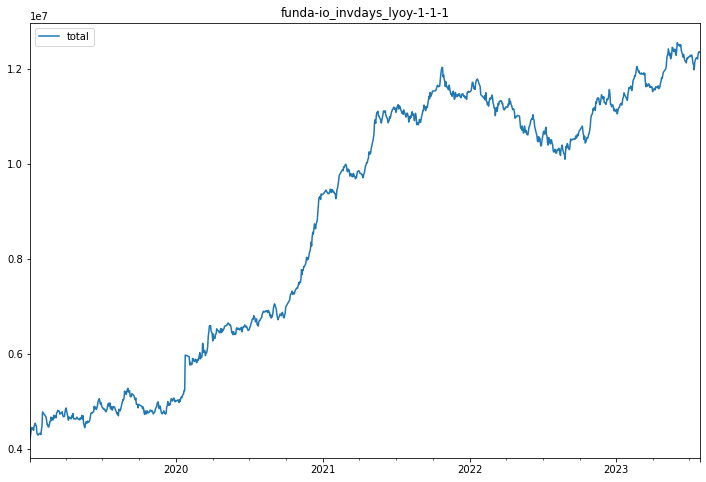

       sharpe       std  sortino
tenor                           
all      1.44  65934.71     2.37
6m       1.72  62639.49     2.69
1y       1.92  64886.90     2.99
2y       0.65  67826.54     1.05
3y       1.83  65998.27     3.10
4y       1.77  68228.00     3.14
5y       1.77  66634.56     3.13
6y       1.75  66125.42     3.07
7y       1.61  65194.15     2.77
8y       1.59  65806.15     2.60
9y       1.44  65934.71     2.37
10y      1.44  65934.71     2.37
11y      1.44  65934.71     2.37


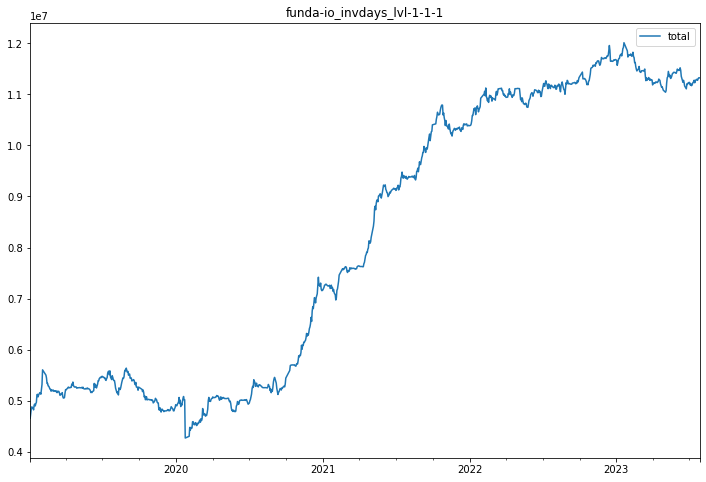

       sharpe       std  sortino
tenor                           
all      1.44  53807.57     1.88
6m      -1.86  46633.73    -2.35
1y       0.22  48369.51     0.28
2y       1.17  52911.20     1.67
3y       2.36  54460.30     3.61
4y       1.62  58068.16     1.96
5y       1.57  56060.92     1.98
6y       1.77  55909.41     2.28
7y       1.53  55004.95     2.00
8y       1.54  55227.16     1.99
9y       1.48  54276.43     1.93
10y      1.44  53807.57     1.88
11y      1.44  53807.57     1.88


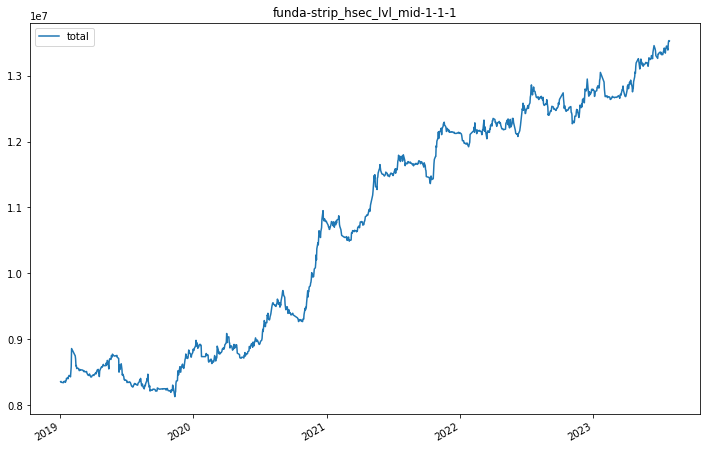

       sharpe       std  sortino
tenor                           
all      1.55  44725.36     2.27
6m       1.33  45396.56     1.83
1y       1.08  48239.92     1.42
2y       1.21  48571.35     1.74
3y       1.83  49597.02     2.85
4y       1.71  48743.88     2.60
5y       1.45  48694.47     2.18
6y       1.41  47666.18     2.14
7y       1.50  47464.63     2.30
8y       1.70  48680.91     2.66
9y       1.67  49080.90     2.49
10y      1.71  48351.10     2.57
11y      1.65  46850.79     2.46


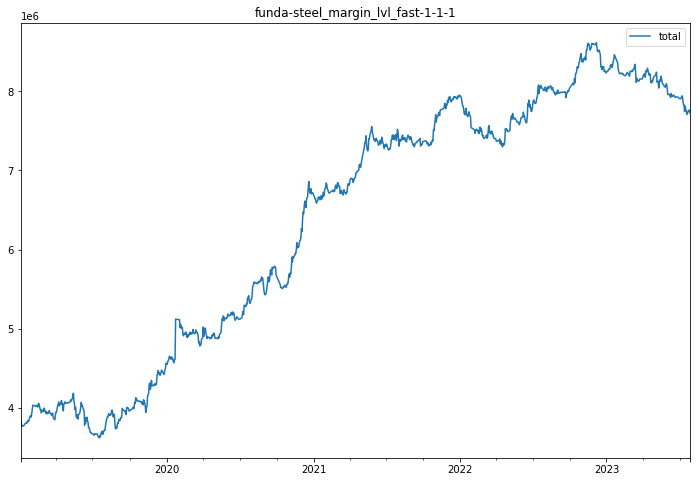

       sharpe       std  sortino
tenor                           
all      1.32  45283.41     2.00
6m      -2.62  35624.41    -2.98
1y      -0.55  36232.02    -0.66
2y       0.28  38921.58     0.40
3y       1.25  40978.39     1.91
4y       1.49  43565.60     2.45
5y       1.26  42805.04     1.99
6y       1.45  41558.73     2.29
7y       1.35  42044.10     2.11
8y       1.31  44126.84     2.03
9y       1.32  45283.41     2.00
10y      1.32  45283.41     2.00
11y      1.32  45283.41     2.00


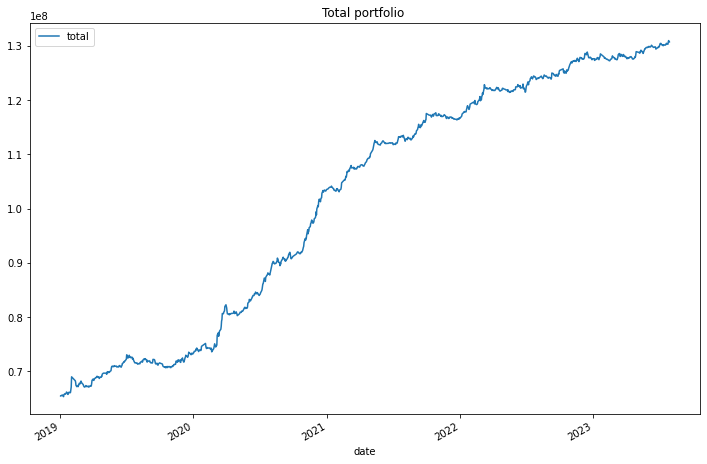

       sharpe        std  sortino
tenor                            
all      3.08  216912.14     5.03
6m       1.41  196827.91     2.50
1y       1.94  218197.02     3.21
2y       2.32  242694.88     3.77
3y       3.50  261775.12     6.04
4y       3.52  270192.14     6.23
5y       3.45  265154.02     6.15
6y       3.50  256777.90     6.18
7y       3.38  256651.47     5.93
8y       3.40  256444.70     5.95
9y       3.27  249090.54     5.67
10y      3.30  239505.35     5.63
11y      3.25  230540.89     5.46
pnl per trade: product
rb     61.698346
hc    110.513784
i     169.500134
j      94.159960
jm     77.390522
ru     24.279076
FG     66.332295
SM     89.842280
SF    132.631110
cu      9.620303
al     29.392220
zn      8.354398
sn     37.977763
l      17.171732
pp     36.533462
v      47.976214
TA     55.699421
sc    125.114221
m      20.603960
RM     15.167946
y      42.291187
p      52.714896
OI     34.567765
a       2.863923
c       2.213484
CF      4.528435
jd     20.774685
AP     9

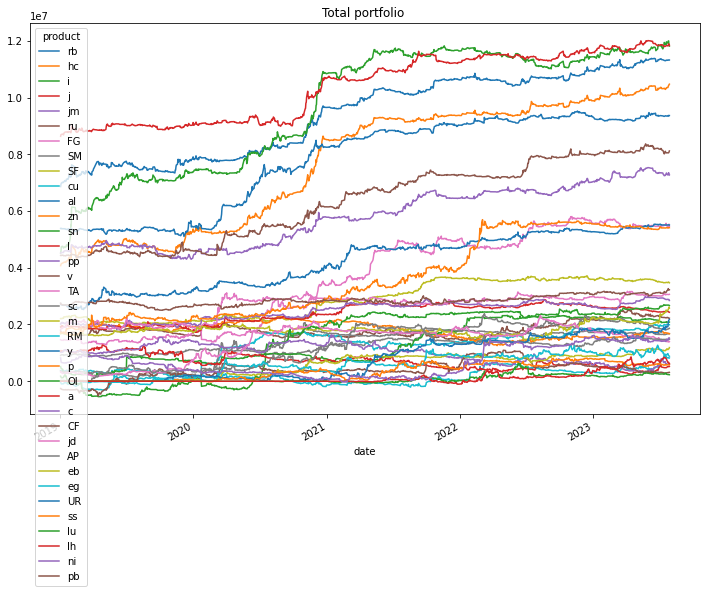

product           rb        hc         i         j        jm        ru  \
sharpe      1.554362  1.910894  1.691042  1.839982  1.455809  0.500808   
sharpe_6m   0.821457  1.732120  0.711242 -0.005788  0.431819 -0.307081   
sharpe_1y   1.274956  1.613401  1.129749  0.957715  1.130878  0.951805   
sharpe_2y   1.245964  1.402758  0.189726  1.014620  1.320261  0.698001   
sharpe_3y   1.942558  2.528016  1.798917  1.689022  1.570764  0.434903   
sharpe_4y   1.712557  2.337172  1.710864  1.365191  1.221671  0.242412   
sharpe_5y   1.549734  1.986109  1.944182  1.437254  1.226506  0.215442   
sharpe_6y   1.605295  1.931043  1.874737  1.569037  1.354334  0.459582   
sharpe_7y   1.509287  1.908078  1.928348  1.721365  1.352464  0.432281   
sharpe_8y   1.617226  1.966758  1.915929  1.731018  1.440954  0.394478   
sharpe_9y   1.681830  1.953813  1.753653  1.736905  1.328144  0.508523   
sharpe_10y  1.727459  1.910894  1.691042  1.811185  1.452128  0.538938   
sharpe_11y  1.710119  1.910894  1.6910

In [10]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = tday

scenario_map = {
    'test': scenarios_test,
    'prod': scenarios_prod,    
}

shift_mode = 2
rev_char = '!'
exec_mode = 'open'
unit_risk = 10_000
asset_scaling = False
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'SM', 'SF', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni', 'pb']

# product_list = ['rb', 'hc', 'i', 'j', 'jm', 'FG', 'al', 'v', 'SM', 'SF']
# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'prod'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        prod_list = [prod for prod in product_list if prod not in ['SM', 'SF']]        
        run_args['product_list'] = prod_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]            
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
        elif signal_name == 'leader_lagger':
            run_args['product_list'] = ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'v', 'al', 'SF', 'UR', 
                                        'sc', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI',]
            run_args['conv_func'] = 'qtl'
            run_args['signal_func'] = leader_lagger
    elif sim_type == 'funda':
        run_args['product_list'] = pos_map 
        run_args['signal_func'] = custom_funda_signal
        run_args['funda_data'] = spot_df
        run_args['signal_cap'] = params
        run_args['signal_name'] = signal_name
        run_args['signal_type'] = rebal
        if 'lme_base' in signal_name:
            run_args['exec_mode'] = 'close'
    run_args['total_risk'] = unit_risk * len(run_args['product_list'])
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    #pnl_stats['asset_cumpnl'][port_start:].plot(title=run_name)
    #plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    #print('pnl per trade: %s, turnover: %s\n' % (pnl_stats['pnl_per_trade'], pnl_stats['turnover']))
    #print(pnl_stats['asset_sharpe_stats'].round(2))
    #print(bt_metrics.holdings.tail(10))
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list] #.reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))
print('pnl per trade: %s, turnover: %s\n' % (port_stats['pnl_per_trade'], port_stats['turnover']))

port_stats['asset_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
print(port_stats['asset_sharpe_stats'])
bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
holdings[run_key] = pos_sum[product_list].divide(close_prices[product_list])
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


<AxesSubplot:xlabel='date'>

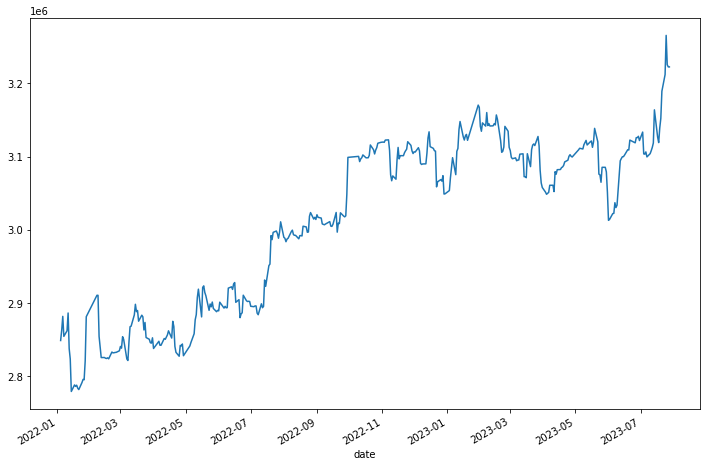

In [14]:
port_stats['asset_cumpnl']['pb']['2022-01-01':].plot()

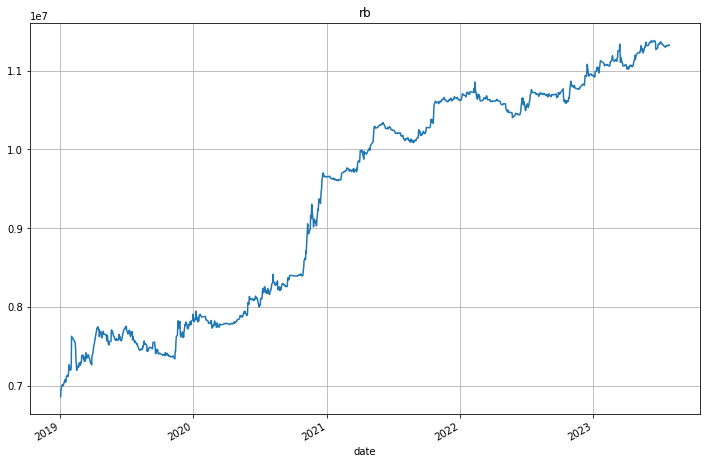

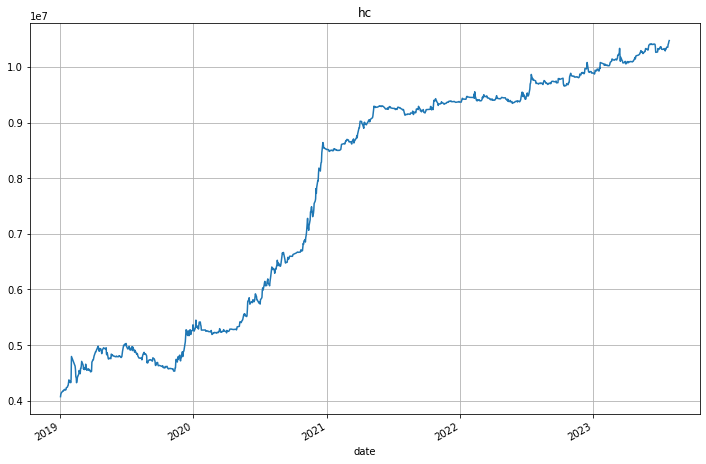

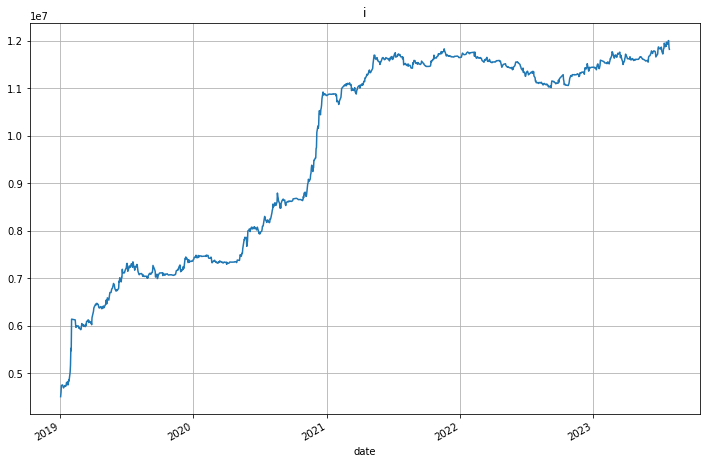

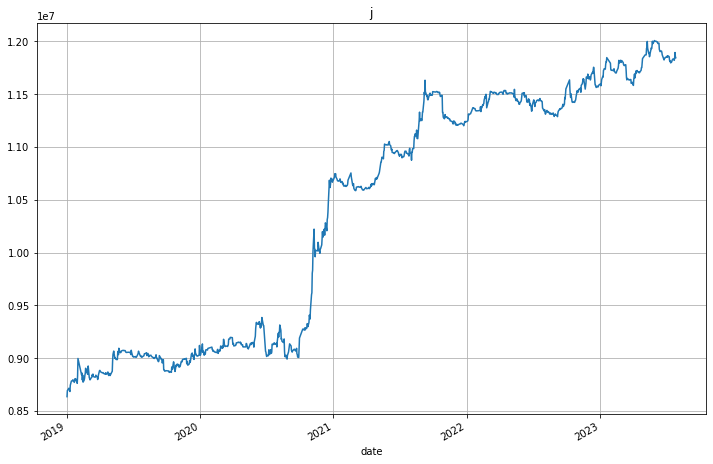

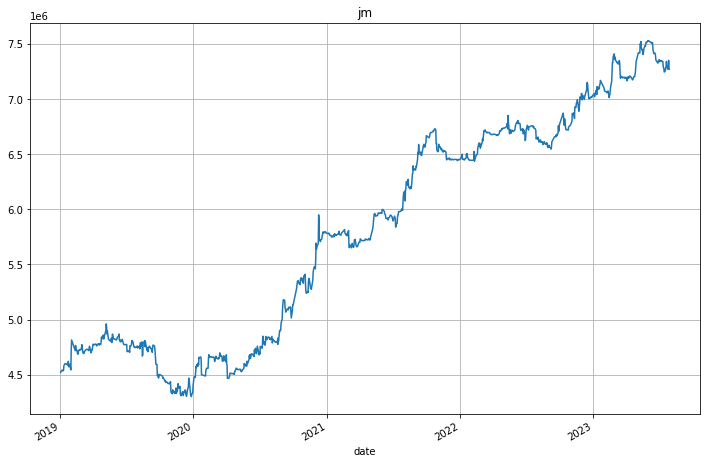

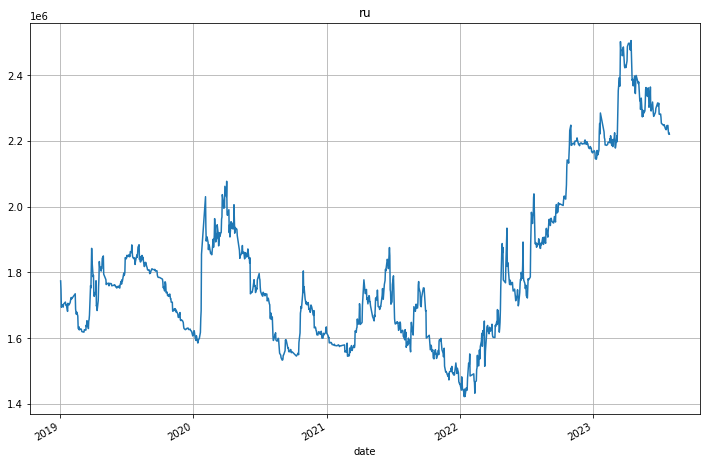

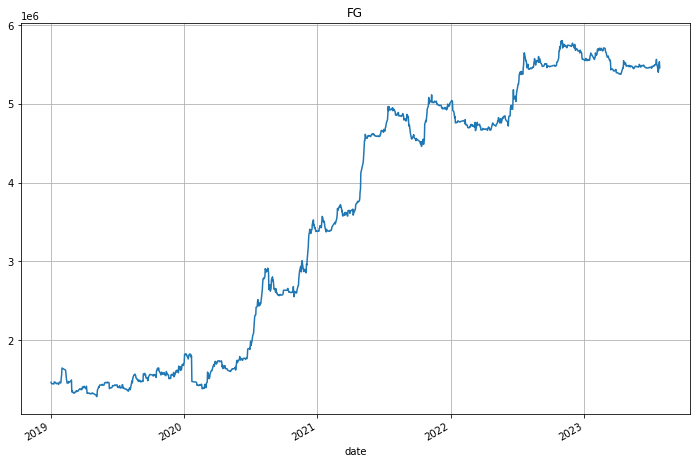

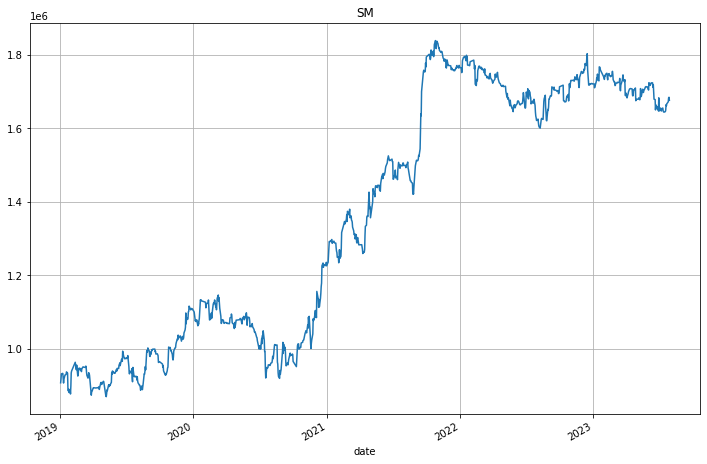

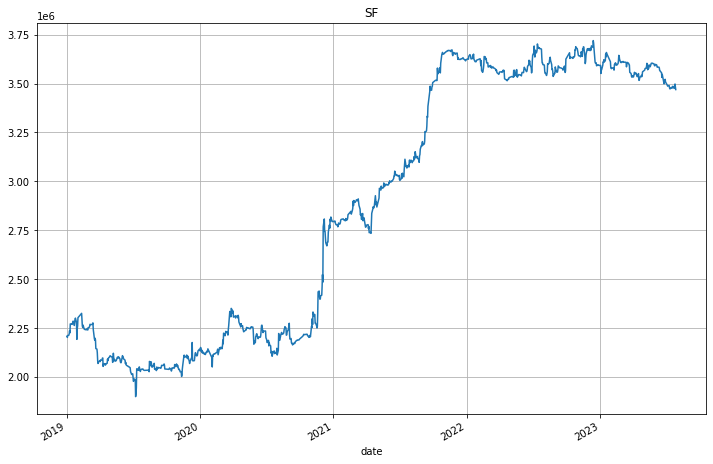

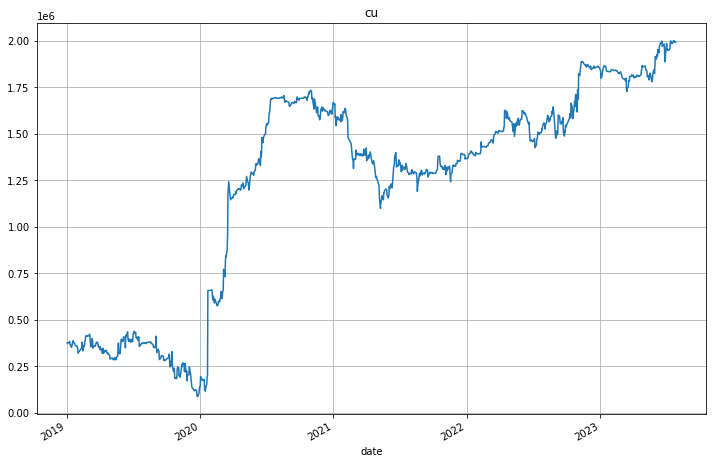

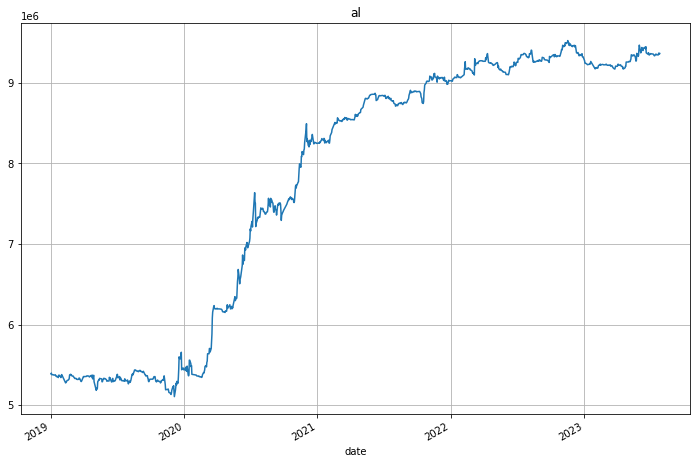

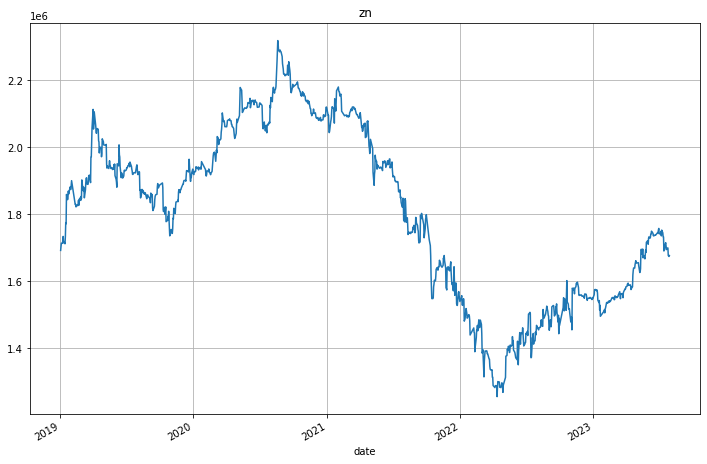

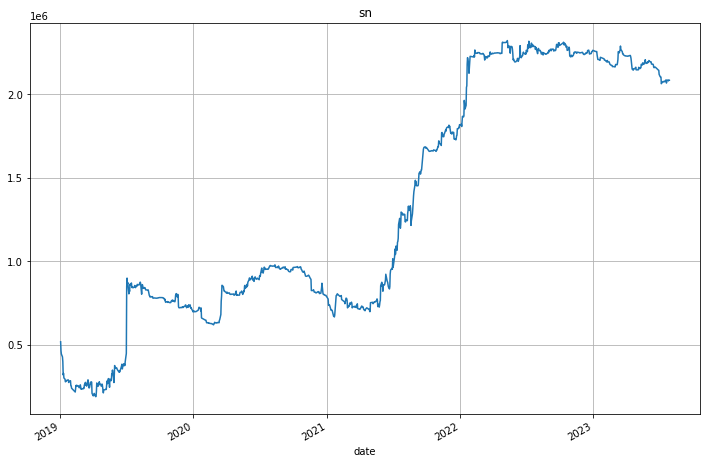

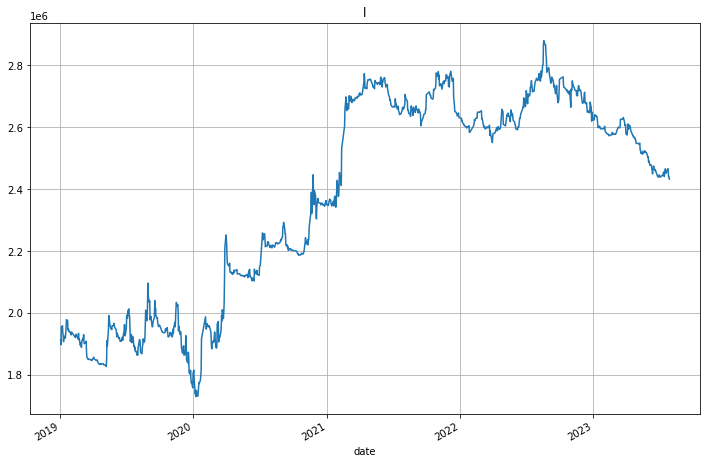

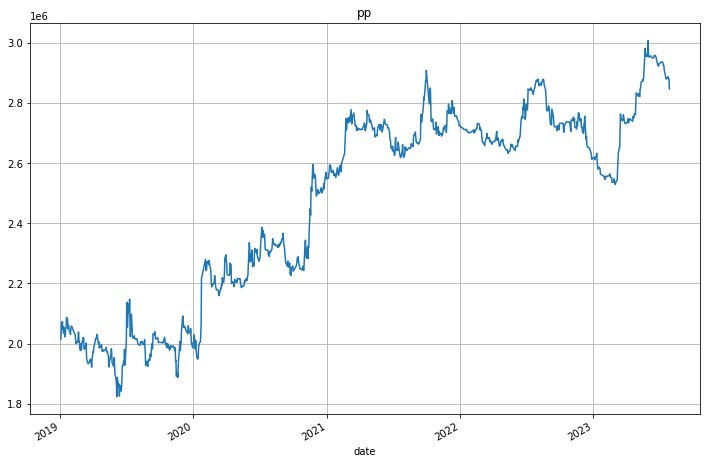

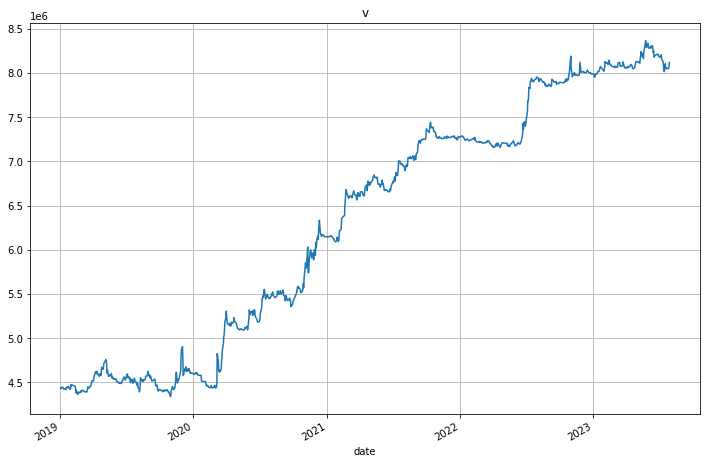

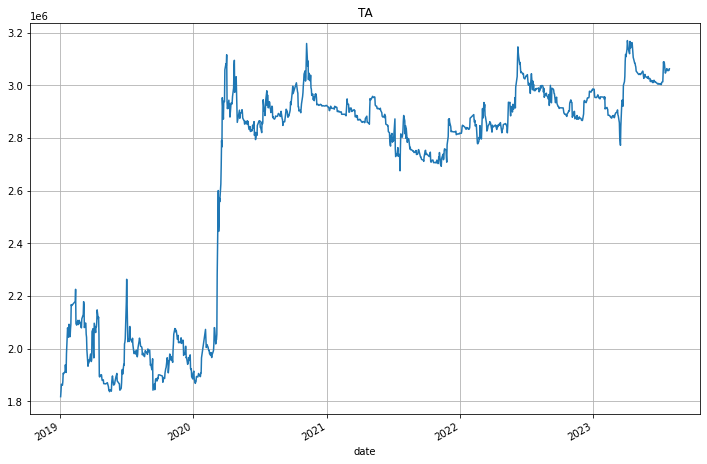

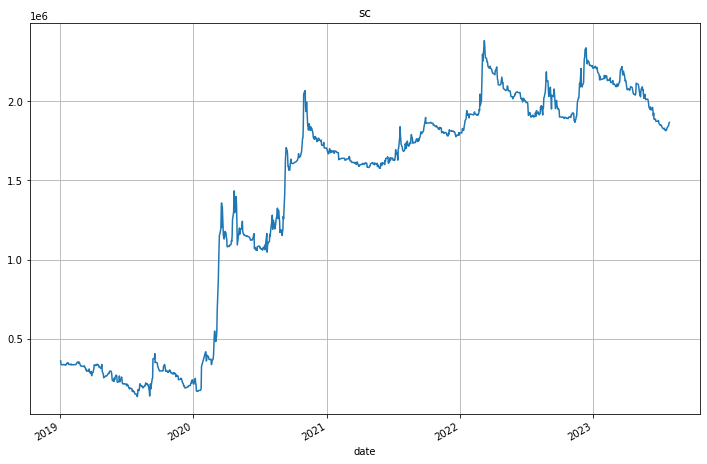

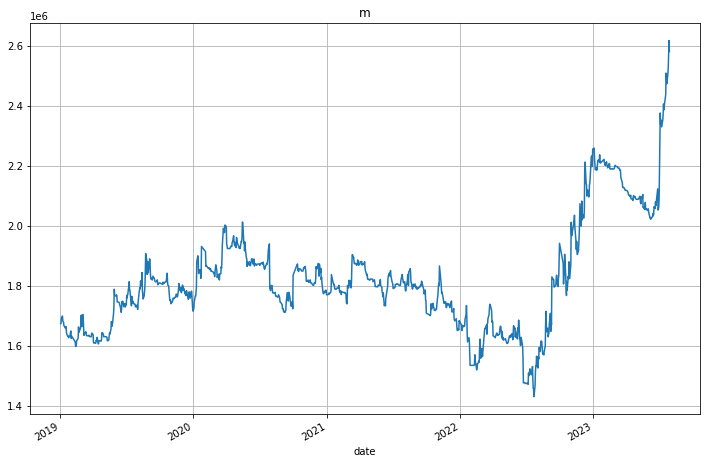

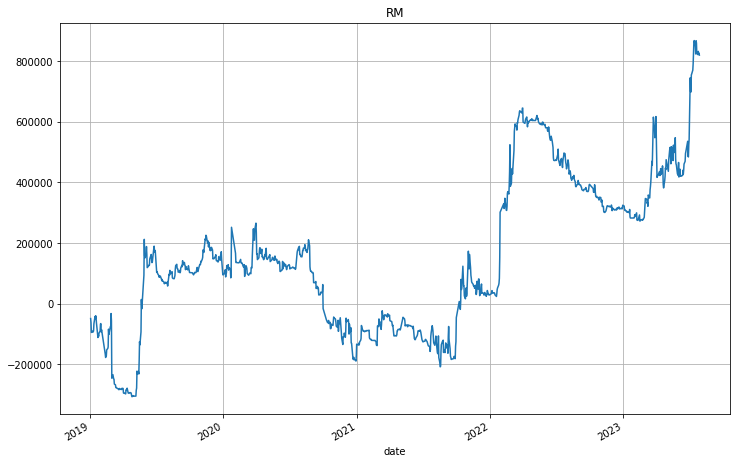

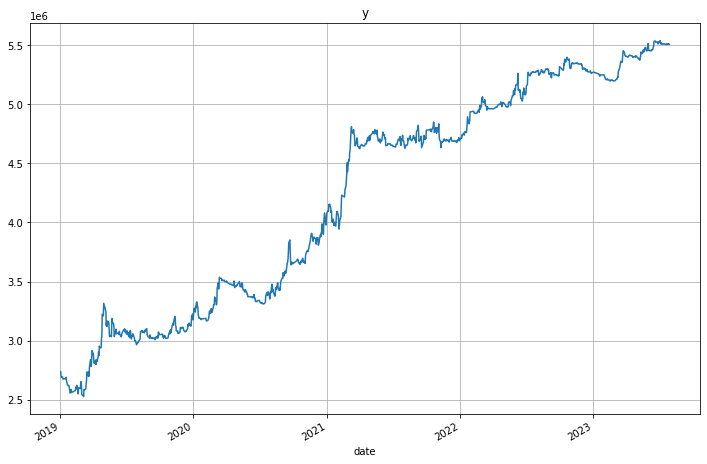

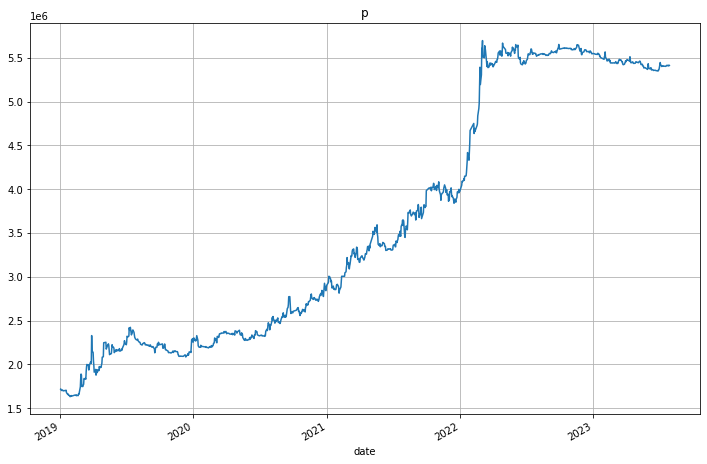

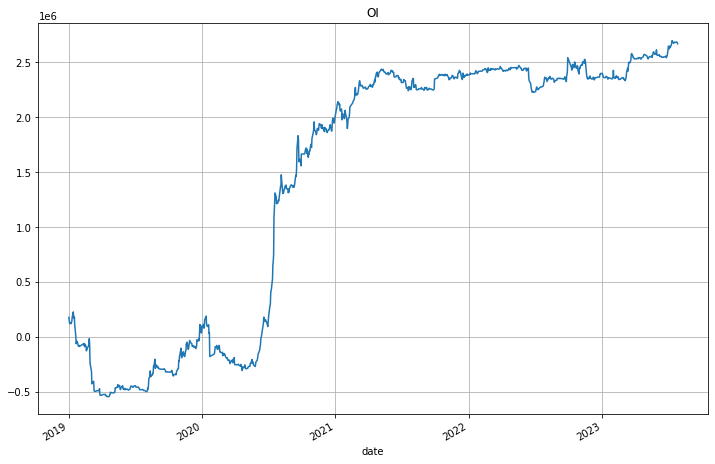

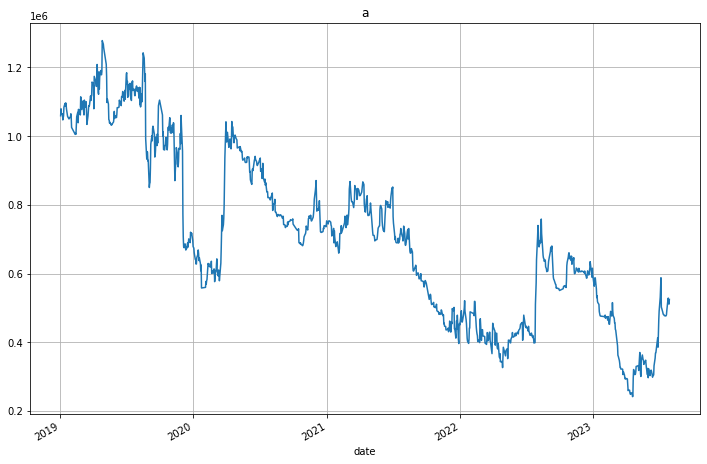

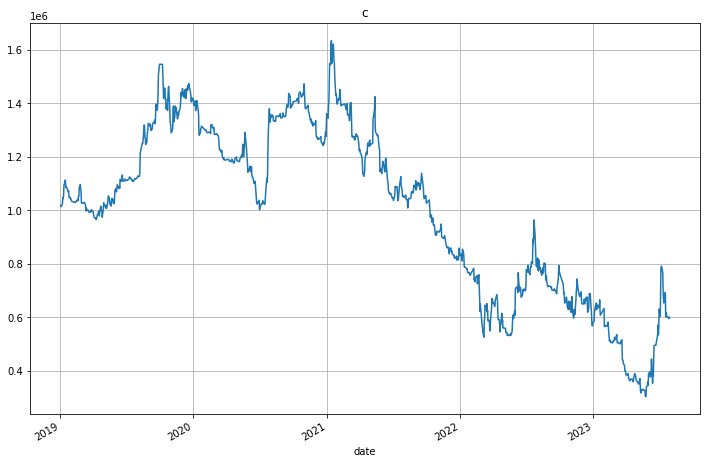

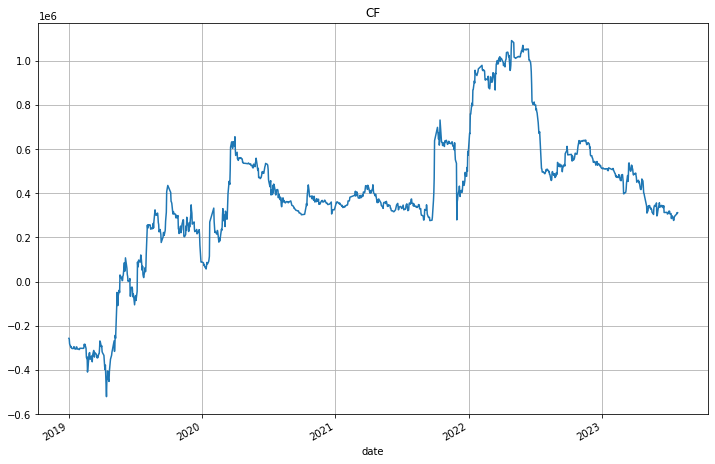

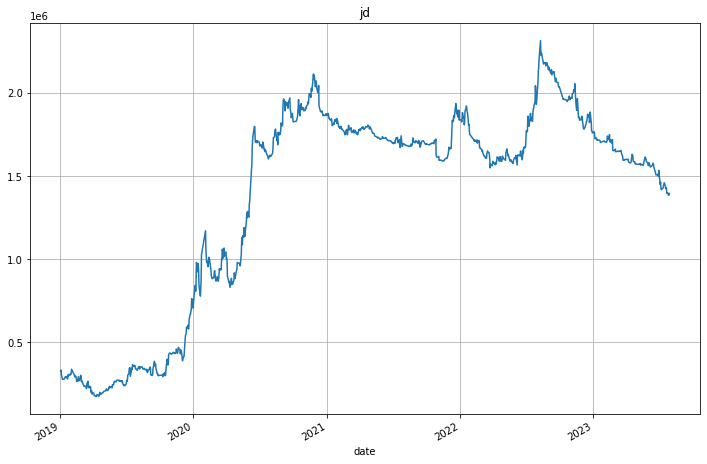

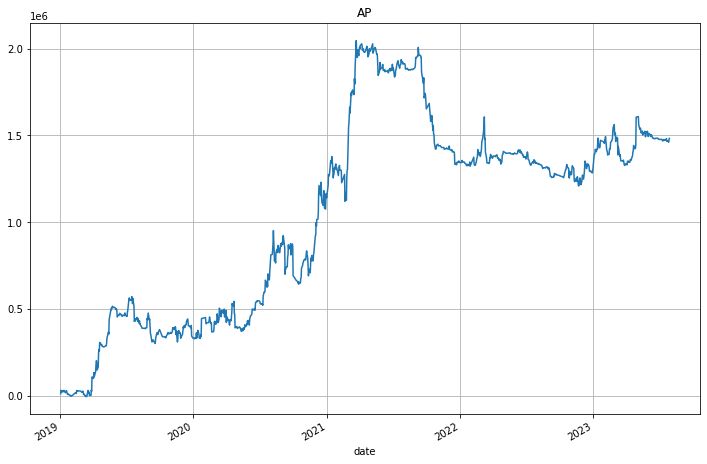

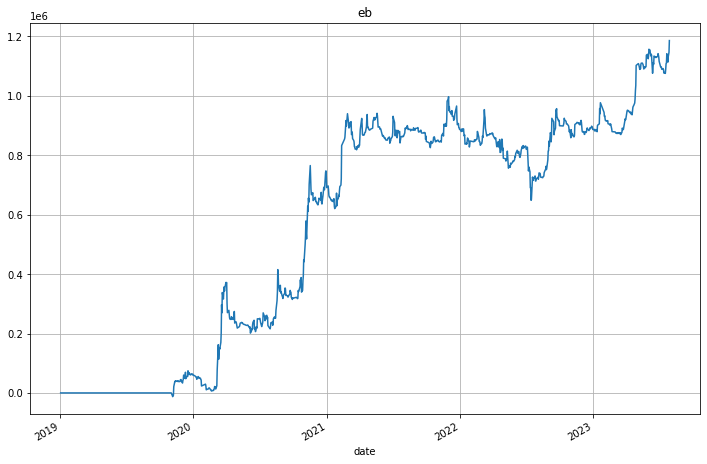

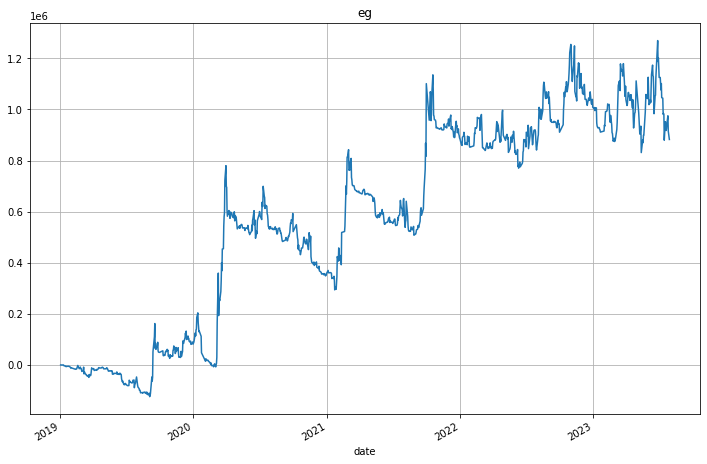

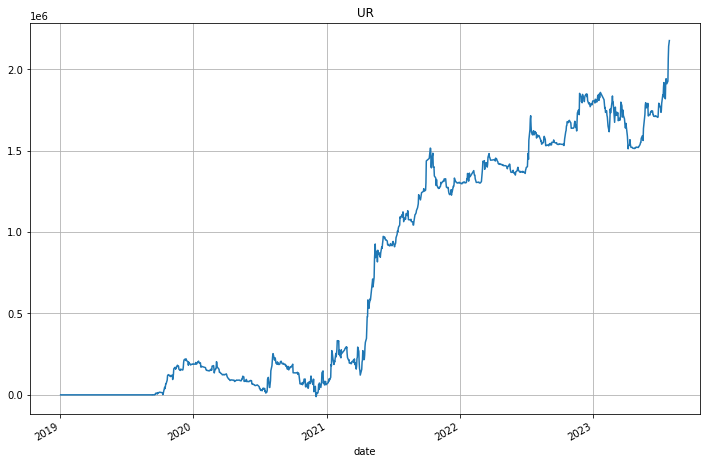

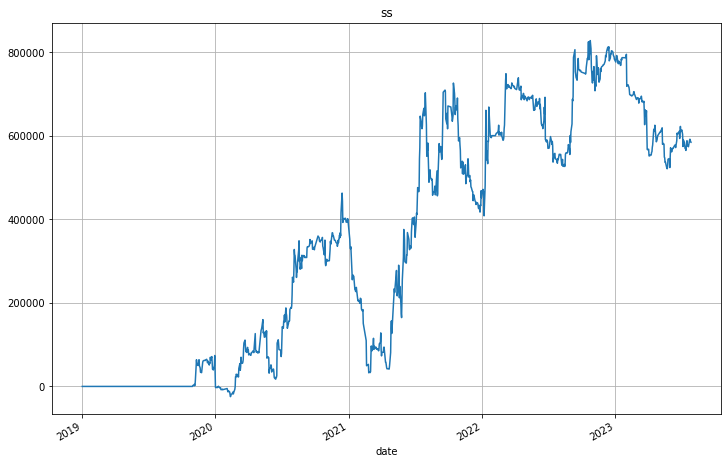

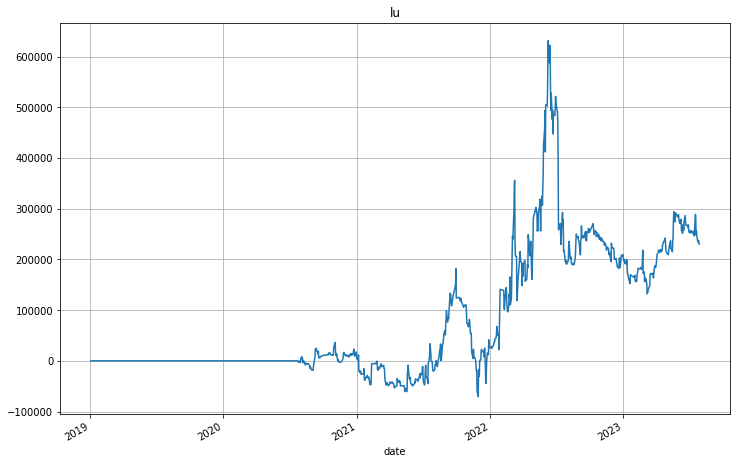

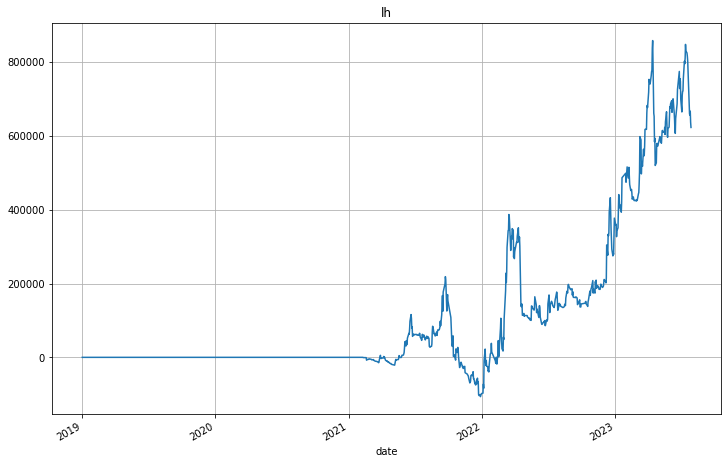

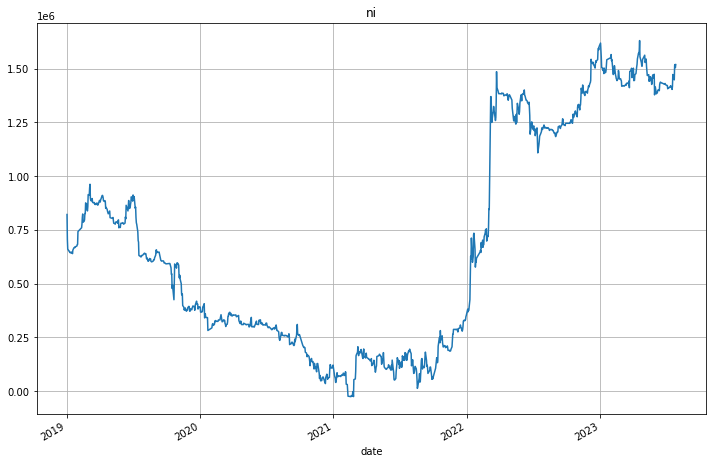

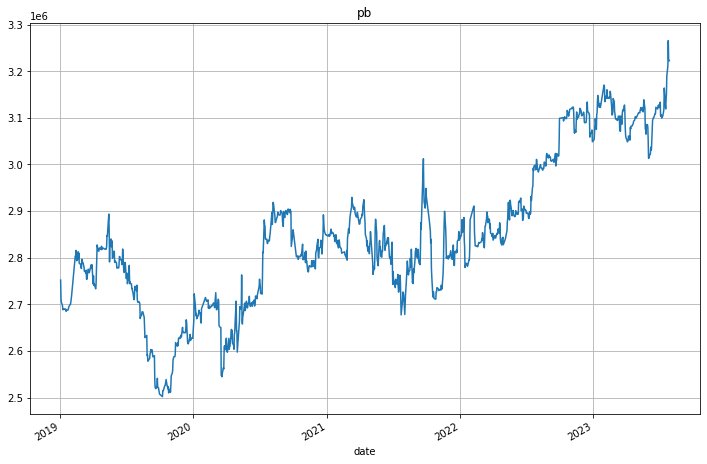

In [12]:
#pnl_stats = bt_empirics[run_key].calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])

#pnl_stats['asset_sharpe_stats']

for asset in port_stats['asset_cumpnl'].columns:
    port_stats['asset_cumpnl'][asset]['2019-01-01':].plot(title=asset)
    plt.grid()
    plt.show()

In [15]:
holdings[run_key]

product,rb,hc,i,j,jm,ru,FG,SM,SF,cu,al,zn,sn,l,pp,v,TA,sc,m,RM,y,p,OI,a,c,CF,jd,AP,eb,eg,UR,ss,lu,lh,ni,pb
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-10,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24,590.294485,824.873446,5627.211991,390.531081,1048.950372,-137.434908,1875.568520,167.713021,147.355146,-27.428247,54.863126,-92.405363,-4.519524,-265.244842,-159.075878,-22.435125,141.274440,2504.506481,673.656217,240.083468,-99.271058,-80.056002,-22.417454,-394.767686,135.187350,93.476543,102.608494,23.119454,266.168014,-802.476687,955.503141,79.911921,-131.928626,-165.922733,12.803110,454.145108
2023-07-25,231.915687,566.003016,5062.768076,785.766877,1178.183785,-177.924526,1929.877508,222.775964,281.454266,-8.263817,127.925052,-55.400488,-3.172839,-315.242571,-117.472155,-64.229797,49.920986,1381.401134,818.305277,179.719773,-91.363615,-109.818557,-41.608542,-434.417981,83.366426,91.892927,435.090919,167.844298,202.742708,-1015.414823,969.821975,120.799965,-160.158342,-71.685877,17.096861,505.222853
2023-07-26,250.427135,524.112968,6048.018159,1129.545604,1469.469503,-156.911184,1882.545898,238.307508,322.325660,-2.083580,127.379331,-5.291474,3.144865,-236.306414,-40.021212,78.173698,47.564891,2324.662139,897.691739,413.603665,-35.403598,-56.159441,-33.510691,-587.104892,-83.353679,89.044164,316.272070,127.272696,274.300021,-413.076842,997.447304,64.539364,13.538335,-63.868925,14.453527,473.975243
2023-07-27,346.792177,773.654126,7350.385295,1448.849509,1880.493194,-117.349565,1999.442496,240.875328,392.366683,-1.393508,109.607795,-71.705434,0.505738,-47.617837,-221.830160,217.833886,3.321802,2362.559211,890.236377,346.195772,-13.672548,17.796086,144.824534,-519.713553,354.155652,100.179445,229.964186,125.571263,305.374529,-469.842863,958.197715,15.922590,-90.337420,-69.950288,9.934809,299.387660
